# Where to sell products [Run analysis notebook]

## Author: Luis Eduardo Ferro Diez, <a href="mailto:luis.ferro1@correo.icesi.edu.co">luis.ferro1@correo.icesi.edu.co</a>

This notebook contains the run as-is code necessary to compute the necessary elements of the project.

In [1]:
base_path = "/media/ohtar10/Adder-Storage/datasets/twitter/2013/09"

## Step 1 - Read tweet data as-is

In [2]:
import pandas as pd

tweets_path = base_path + "/pruned/tweets/"
tweets = pd.read_parquet(tweets_path, engine="pyarrow")
tweets.head()

id                                              tweet lang  \
0  384905527706542080  I'm at Mahatma Gading Nasional Plus School (Ja...   id   
1  384905536107319296  But I honestly don't give a fuck, because I di...   en   
2  384905548690653184  Metcalfe / Sainte-Catherine: 01:00 - Disponibl...   de   
3  384905548690255872                Ask te odio pero a la ves te amo :)   es   
4  384905552855592961  "@ThelIluminati: The #governmentshutdown but t...   en   

   favorite_count  retweet_count  is_retweet    user_id     user_name  \
0             0.0            0.0         0.0  234670148    richardgbt   
1             0.0            0.0         0.0   28929946  rachelzerber   
2             0.0            0.0         0.0  162780830   BixTweet057   
3             0.0            0.0         0.0   38001073     bernageek   
4             0.0            0.0         0.0  297722693    wifi_whor3   

   user_followers_count  user_following_count  ...       place_name  \
0                 306.0                 280.0  ...      Pulo Gadung   
1                 344.0                 124.0  ...          Arizona   
2                   3.0                   0.0  ...         Montréal   
3                 728.0                 469.0  ...  Pachuca de Soto   
4                 372.0                 708.0  ...         Pasadena   

              place_full_name        country country_code place_type  \
0  Pulo Gadung, Jakarta Timur      Indonesia           ID       city   
1                 Arizona, US  United States           US      admin   
2            Montréal, Québec         Canada           CA       city   
3    Pachuca de Soto, Hidalgo         México           MX       city   
4                Pasadena, TX  United States           US       city   

                                           place_url  year month day hour  
0  https://api.twitter.com/1.1/geo/id/8496c55fb5d...  2013    10   1    0  
1  https://api.twitter.com/1.1/geo/id/a612c69b44b...  2013    10   1    0  
2  https://api.twitter.com/1.1/geo/id/378a442883b...  2013    10   1    0  
3  https://api.twitter.com/1.1/geo/id/8747ffc9cc7...  2013    10   1    0  
4  https://api.twitter.com/1.1/geo/id/3e82edc94d5...  2013    10   1    0  

[5 rows x 29 columns]

## Step 2 - Define utility functions
Here we define the `parse_geometry()` function in order to easily get the geometries for a particular field.

In [3]:
from shapely import wkt
import geopandas as gpd

def parse_geometry(geom):
    if geom:
        return wkt.loads(geom)
    else:
        return None

## Step 3 - Create a `TweetByField` Selector
We are not going to perform the analysis over all world data, just United States and selected place names, hence it is handy to create a transformer that help us to filter by particular fields.

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin

class TweetSelectorByFields(BaseEstimator, TransformerMixin):
    
    def __init__(self, field_values):
        self.field_values = field_values
        
    def fit(self, X, y=None):
        return self # do nothing
    
    def transform(self, X, y=None):
        data = X.copy()
        for field, value in self.field_values.items():
            data = data[data[field].isin([value])]
        return data

In [6]:
field_values = {"country_code": "US"}
tweet_selector = TweetSelectorByFields(field_values=field_values)
selected_tweets = tweet_selector.transform(tweets)
selected_tweets.head()

id                                              tweet lang  \
1  384905536107319296  But I honestly don't give a fuck, because I di...   en   
4  384905552855592961  "@ThelIluminati: The #governmentshutdown but t...   en   
5  384905569653358592                      Magic mike on TV? I think yes   en   
6  384905586438971392                    @emilyparkhurst Yes! Thank you!   en   
7  384905586435190785          @AndrewJerdonek don't forget about meeeee   en   

   favorite_count  retweet_count  is_retweet     user_id     user_name  \
1             0.0            0.0         0.0    28929946  rachelzerber   
4             0.0            0.0         0.0   297722693    wifi_whor3   
5             0.0            0.0         0.0  1124221580      Gabers22   
6             0.0            0.0         0.0    17953151      WhitneyT   
7             0.0            0.0         0.0   330831579  AustinRich61   

   user_followers_count  user_following_count  ...  place_name  \
1                 344.0                 124.0  ...     Arizona   
4                 372.0                 708.0  ...    Pasadena   
5                  35.0                  88.0  ...     Anaheim   
6                1555.0                1202.0  ...     Edmonds   
7                 221.0                 319.0  ...  New Albany   

  place_full_name        country country_code place_type  \
1     Arizona, US  United States           US      admin   
4    Pasadena, TX  United States           US       city   
5     Anaheim, CA  United States           US       city   
6     Edmonds, WA  United States           US       city   
7  New Albany, IN  United States           US       city   

                                           place_url  year month day hour  
1  https://api.twitter.com/1.1/geo/id/a612c69b44b...  2013    10   1    0  
4  https://api.twitter.com/1.1/geo/id/3e82edc94d5...  2013    10   1    0  
5  https://api.twitter.com/1.1/geo/id/0c2e6999105...  2013    10   1    0  
6  https://api.twitter.com/1.1/geo/id/eaa5a4f94dc...  2013    10   1    0  
7  https://api.twitter.com/1.1/geo/id/ec5febdaca1...  2013    10   1    0  

[5 rows x 29 columns]

## Step 4 - Define the tweets transformer
This is to take only the necessary data and parse the geometries. A simple sklearn transformer

In [38]:
DEFAULT_COLUMNS = ["id",
                   "tweet", 
                   "country",
                   "country_code",
                   "place_name",
                   "place_full_name",
                   "location_geometry", 
                   "place_geometry",
                   "created_timestamp"]

class TweetsTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, geometry_field, columns=DEFAULT_COLUMNS):
        self.geometry_field = geometry_field
        self.columns = columns
    
    def fit(self, X, y=None):
        return self # do nothing
        
    def transform(self, X, y=None):
        data = X[self.columns]
        data = data[data[self.geometry_field].notnull()]
        data[self.geometry_field] = data[self.geometry_field].apply(parse_geometry)
        return gpd.GeoDataFrame(data, geometry=self.geometry_field)

In [39]:
tweets_transformer = TweetsTransformer(geometry_field="location_geometry")
transformed_tweets = tweets_transformer.transform(selected_tweets)
transformed_tweets.head()

id                                              tweet  \
1  384905536107319296  But I honestly don't give a fuck, because I di...   
4  384905552855592961  "@ThelIluminati: The #governmentshutdown but t...   
5  384905569653358592                      Magic mike on TV? I think yes   
6  384905586438971392                    @emilyparkhurst Yes! Thank you!   
7  384905586435190785          @AndrewJerdonek don't forget about meeeee   

         country country_code  place_name place_full_name  \
1  United States           US     Arizona     Arizona, US   
4  United States           US    Pasadena    Pasadena, TX   
5  United States           US     Anaheim     Anaheim, CA   
6  United States           US     Edmonds     Edmonds, WA   
7  United States           US  New Albany  New Albany, IN   

                   location_geometry  \
1  POINT (-112.44060223 33.72698491)   
4   POINT (-95.16610589 29.64126961)   
5  POINT (-118.00539787 33.82445792)   
6  POINT (-122.35089499 47.81954805)   
7    POINT (-85.8097477 38.31402102)   

                                      place_geometry   created_timestamp  
1  POLYGON ((-114.816591 31.332176999999998, -109... 2013-10-01 05:00:05  
4  POLYGON ((-95.234542 29.557836, -94.982683 29.... 2013-10-01 05:00:09  
5  POLYGON ((-118.017597 33.788835, -117.674604 3... 2013-10-01 05:00:13  
6  POLYGON ((-122.434346 47.777595, -122.319615 4... 2013-10-01 05:00:17  
7  POLYGON ((-85.864385 38.257299, -85.782947 38.... 2013-10-01 05:00:17

## Step 5 - Count tweets per place and plot results
Here we execute simple counts and groupings as well as defining functions to plot some results
### Step 5.1 - Compute counts

In [40]:
def flat_columns(df, colnames={}):
    df = df.copy()
    df.columns = [''.join(col).strip() for col in df.columns]
    if colnames:
        return df.rename(columns=colnames)
    return df

In [41]:
class TweetCountTransformer(TransformerMixin):
    
    def __init__(self, groupby, min_count=5000):
        self.min_count = 5000
        self.groupby = groupby
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        data = X.copy()
        data = data.groupby(self.groupby).agg({"tweet": ["count"]})
        data = flat_columns(data)
        data = data[data["tweetcount"] >= self.min_count]
        data.reset_index(inplace=True)
        data.sort_values("tweetcount", ascending=False, inplace=True)
        return data

In [42]:
tweet_count_transformer = TweetCountTransformer(groupby="place_name")
tweet_count = tweet_count_transformer.transform(transformed_tweets)
tweet_count.head(10)

place_name  tweetcount
3   Los Angeles        9025
8         Texas        7453
5      New York        6712
2       Georgia        6541
4     Manhattan        6451
0       Chicago        5585
1       Florida        5470
7  Philadelphia        5177
6          Ohio        5080

### Step 5.2 Plot the results

In [43]:
import matplotlib.pyplot as plt
import numpy as np

def plot_tweet_counts(data, save_path=None):
    min_val = 0
    max_val = max(data.tweetcount.values)
    ax = data.set_index("place_name").plot(kind="bar", 
                     figsize=(10, 8),
                     fontsize=12,
                     grid=True,
                     yticks=np.arange(min_val, max_val + 1, 1000.0))

    ax.set_xlabel("City", fontsize=14)
    ax.set_ylabel("Count", fontsize=14)
    ax.set_title("Tweet count by place_name in the US", fontsize=16)
    plt.legend(prop={"size": 14})
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    else:
        plt.show()

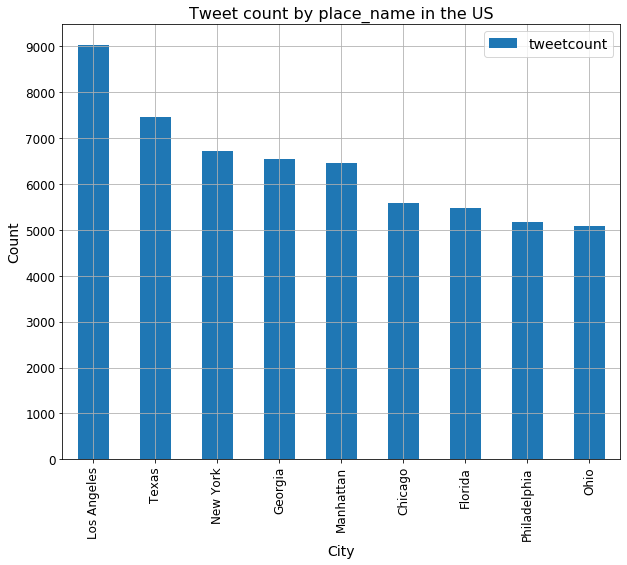

In [44]:
%matplotlib inline
plot_tweet_counts(tweet_count, save_path="./us_tweet_count.png")

## Step 6 - Preprocess selected tweets for cluster training
At this point we should have tweets filtered by country and we can manually select a city to train a cluster too. Now, we want to train the clusters, first, we need to prepare the data to enable the training of DBSCAN. First, we need also to train a Nearest Neighbors model to know the best distance parameter to use with DBSCAN. For both models the preparation/transformation is the same.

### Step 6.1 Transform geo-tweets into points

In [53]:
class TweetPointTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, location_column, only_points=False):
        self.location_column = location_column
        self.only_points = only_points
    
    def fit(self, X, y=None):
        return self # do nothing
    
    def transform(self, X, y=None):
        data = X[X[self.location_column].notnull()]
        points = data[self.location_column].apply(lambda p: [p.x, p.y])
        if self.only_points:
            points = np.array(points.values.tolist())
            return points
        else:
            data["location_coordinats"] = points
            return data

In [54]:
tweet_point_transformer = TweetPointTransformer(location_column="location_geometry", only_points=False)
tweet_points = tweet_point_transformer.transform(transformed_tweets)
tweet_points.head()

id                                              tweet  \
1  384905536107319296  But I honestly don't give a fuck, because I di...   
4  384905552855592961  "@ThelIluminati: The #governmentshutdown but t...   
5  384905569653358592                      Magic mike on TV? I think yes   
6  384905586438971392                    @emilyparkhurst Yes! Thank you!   
7  384905586435190785          @AndrewJerdonek don't forget about meeeee   

         country country_code  place_name place_full_name  \
1  United States           US     Arizona     Arizona, US   
4  United States           US    Pasadena    Pasadena, TX   
5  United States           US     Anaheim     Anaheim, CA   
6  United States           US     Edmonds     Edmonds, WA   
7  United States           US  New Albany  New Albany, IN   

                   location_geometry  \
1  POINT (-112.44060223 33.72698491)   
4   POINT (-95.16610589 29.64126961)   
5  POINT (-118.00539787 33.82445792)   
6  POINT (-122.35089499 47.81954805)   
7    POINT (-85.8097477 38.31402102)   

                                      place_geometry   created_timestamp  \
1  POLYGON ((-114.816591 31.332176999999998, -109... 2013-10-01 05:00:05   
4  POLYGON ((-95.234542 29.557836, -94.982683 29.... 2013-10-01 05:00:09   
5  POLYGON ((-118.017597 33.788835, -117.674604 3... 2013-10-01 05:00:13   
6  POLYGON ((-122.434346 47.777595, -122.319615 4... 2013-10-01 05:00:17   
7  POLYGON ((-85.864385 38.257299, -85.782947 38.... 2013-10-01 05:00:17   

            location_coordinats  
1  [-112.44060223, 33.72698491]  
4   [-95.16610589, 29.64126961]  
5  [-118.00539787, 33.82445792]  
6  [-122.35089499, 47.81954805]  
7    [-85.8097477, 38.31402102]

#### 6.1.1 Visualize the results

In [80]:
import matplotlib.pyplot as plt

def plot_points(data, title, save_path=None):
    plt.figure(figsize=(10, 8))
    plt.scatter(data[:, 0], data[:, 1], alpha=0.1)
    plt.title(title, fontsize=16)
    plt.xlabel("Longitude", fontsize=14)
    plt.ylabel("Latitude", fontsize=14)
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    else:
        plt.show()

In [81]:
from sklearn.pipeline import Pipeline

place_name = "Los Angeles"
place_points_pipeline = Pipeline(
    [
        ("place_selector", TweetSelectorByFields({"place_name": place_name})),
        ("point_getter", TweetPointTransformer(location_column="location_geometry", only_points=True))
    ]
)

tweet_points = place_points_pipeline.transform(transformed_tweets)

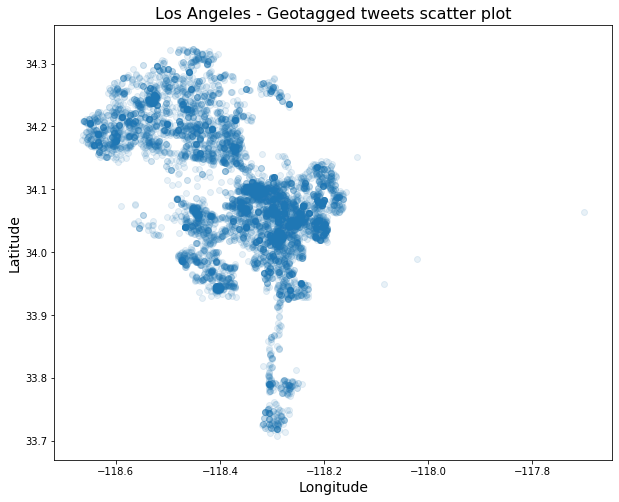

In [82]:
%matplotlib inline


plot_points(tweet_points, title=f"{place_name} - Geotagged tweets scatter plot", save_path="./la_tweets_scatter.png")

### Step 6.2 Train a Nearest Neighbor model with the points

In [89]:
from sklearn.neighbors import NearestNeighbors

n_neighbors = 10

def plot_nearest_neighbors(X, n_neighbors=5, save_path=None):
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    
    plt.figure(figsize=(10, 8))
    plt.grid()
    axes = plt.gca()
    axes.set_ylim([-0.005, 0.02])
    plt.yticks(np.arange(-0.005, 0.02, 0.001))
    plt.title("Nearest Neighbors for Geotagged tweets", fontsize=16)
    plt.ylabel(f"{n_neighbors}th Nearest Neighbor Distance", fontsize=14)
    plt.xlabel(f"Points sorted according to the distance of the {n_neighbors}th Nearest Neighbor", fontsize=14)
    plt.plot(distances)
    
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

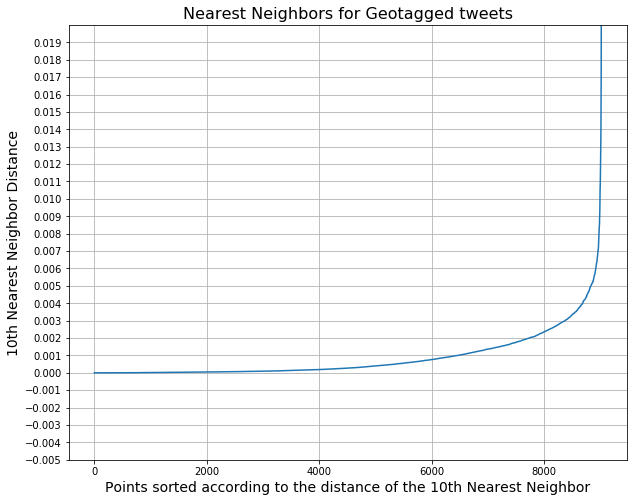

In [90]:
%matplotlib inline

plot_nearest_neighbors(tweet_points, n_neighbors=n_neighbors, save_path="./la_tweets_nn.png")

### Step 6.3 Train the DBSCAN model

In [93]:
%%time
from sklearn.cluster import OPTICS

optics = OPTICS(cluster_method="dbscan",
                eps=0.004,
                min_samples=n_neighbors,
                metric="minkowski",
                n_jobs=-1).fit(tweet_points)

CPU times: user 1min 50s, sys: 34.7 s, total: 2min 24s
Wall time: 16min 30s


In [94]:
import pickle

model_path = '../../models/sklearn/la_dbscan.sav'
with open(model_path, 'wb') as model_file:
    pickle.dump(optics, model_file)

In [95]:
import pickle

model_path = '../../models/sklearn/la_dbscan.sav'
with open(model_path, 'rb') as model_file:
    tweet_clusters = pickle.load(model_file)

In [98]:
from sklearn import metrics

def print_cluster_metrics(points, clusters):
    labels = clusters.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    
    with_noise_sc = metrics.silhouette_score(points, labels)
    
    qpoints, qlabels = list(zip(*[(p, l) for p, l in zip(points, labels) if l != -1]))
    without_noise_sc = metrics.silhouette_score(qpoints, qlabels)

    print('#' * 20)
    print('Including the noise:')
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print(f"Silhouette Coefficient: {with_noise_sc:0.3f}")
    
    print('#' * 20)
    print('Excluding the noise:')
    print(f"Silhouette Coefficient: {without_noise_sc:0.3f}")

In [99]:
print_cluster_metrics(tweet_points, tweet_clusters)

####################
Including the noise:
Estimated number of clusters: 163
Estimated number of noise points: 3264
Silhouette Coefficient: -0.114
####################
Excluding the noise:
Silhouette Coefficient: 0.350


## Step 7 Aggregate the clusters
This step is very important as not only it will label all the tweets with the corresponding cluster but also it will aggergate their text and it will create the polygons corresponding to each cluster.

Text aggregation is necessary because this is what will be submitted to the product classifier. Polygon calculation is needed because this is the way we are going to present the results at the end.

In [101]:
from shapely.geometry import Polygon, Point
from scipy.spatial import ConvexHull
import numpy as np

def concatenate_text(sep='\n'):
    """Concatenate Text
    This function will simply join every
    text it receives as a single text and
    separate it by the provide separator.
    Default \n """
    def concat(text):
        return '.\n'.join(text)
    return concat

def calculate_polygon(points):
    """Calculate polygon
    This function will calculate the polygon
    enclosing all the points provided as argument.
    It will use the convex-hull geometric function."""
    points = np.array([list(p.coords[0]) for p in points])
    hull = ConvexHull(points)
    x = points[hull.vertices, 0]
    y = points[hull.vertices, 1]
    boundaries = list(zip(x, y))
    
    return Polygon(boundaries)

def is_valid_polygon(cluster):
    points = cluster.location_geometry.values
    if isinstance(points, Point):
        return False
    if points.shape[0] < 3:
        return False
    coords = np.array([p.coords[0] for p in points])
    upoints = np.unique(coords)
    if upoints.shape[0] < 3:
        return False
    return True

In [118]:
class TweetClusterAggregator(BaseEstimator, TransformerMixin):
    
    def __init__(self, clusters, columns, 
                 location_column,
                 agg_colnames,
                 filter_noise=True):
        self.clusters = clusters
        self.columns = columns
        self.location_column = location_column
        self.agg_colnames = agg_colnames
        self.filter_noise = filter_noise
    
    def fit(self, X, y=None):
        return self # do nothing
    
    def transform(self, X, y=None):
        data = X.copy()
        data['cluster'] = self.clusters.labels_
        data = data[["cluster", "tweet"] + self.columns]
        
        if self.filter_noise:
            data = data[data.cluster != -1]
        
        data = data.groupby("cluster").filter(is_valid_polygon)
        data = data.groupby("cluster").agg({
            self.location_column: ['count', calculate_polygon],
            'tweet': [concatenate_text()]
        })
        data = flat_columns(data, self.agg_colnames)
        return data.reset_index()
        

In [121]:
colnames = {'location_geometrycalculate_polygon': 'polygon', 
            'location_geometrycount': 'size',
            'tweetconcat': 'corpus'}

tweets_clusters_pipeline = Pipeline(
    [
        ("place_selector", TweetSelectorByFields({"place_name": place_name})),
        ("tweet_cluster_aggregator", TweetClusterAggregator(tweet_clusters, 
                                           columns=["location_geometry"], 
                                           location_column="location_geometry",
                                           agg_colnames=colnames))
    ]
)

tweet_agg_clusters = tweets_clusters_pipeline.transform(transformed_tweets)
tweet_agg_clusters.head()

cluster  size                                            polygon  \
0        0   266  POLYGON ((-118.22621039 34.0509672, -118.22147...   
1        1   811  POLYGON ((-118.26051611 34.03318081, -118.2352...   
2        2    42  POLYGON ((-118.280023 34.036525, -118.2769755 ...   
3        3    18  POLYGON ((-118.2831933 34.0532053, -118.284239...   
4        4     5  POLYGON ((-118.30088216 34.09520177, -118.3014...   

                                              corpus  
0  Los Nuevos Rebeldes.\nWhy do girls say "can I ...  
1  I'm at Piero (Los Angeles, CA) http://t.co/cEB...  
2  @MariaJose_Dleon gracias jajaja igualmente par...  
3  She keepa laughing at the stupidest shit -_-.\...  
4  "Never get too attached to anyone unless they ...

## Step 8 Visualize the clusters in a map
We are going to tackle this in two ways, first, by showing the points as they are, colored according to the assigned cluster, and then computing a polygon per cluster and present the map with colored polygons corresponding to each cluster.

##### Note:
From this point onwards we are excluding the noise points from the plotting for simplicity

### Step 8.1 Display the points colored by cluster

In [134]:
from itertools import cycle
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import folium
import random

def plot_tagged_points_on_map(tweets,
                              remove_noise=True,
                              location_column="location_geometry",
                              center=(34, -118), 
                              zoom=10, 
                              tiles="OpenStreetMap"):
    if remove_noise:
        tweets = tweets[tweets["cluster"] != -1]
    unique_clusters = np.unique(tweets.cluster.values)
    n_clusters = unique_clusters.shape[0]
    colormap = cycle(plt.cm.rainbow(np.linspace(0, 1, n_clusters)))
    colors = [matplotlib.colors.to_hex(next(colormap)) for _ in range(len(unique_clusters))]
    random.shuffle(colors)
    colors = {k: c for k, c in zip(unique_clusters, colors)}
    
    m = folium.Map(location=center, 
                zoom_start=zoom,
                tiles=tiles)
    
    def create_marker(row):
        lat_lon = (row[location_column].y, row[location_column].x)
        cluster = row["cluster"]
        color = colors[cluster]
        folium.CircleMarker(
            location=lat_lon,
            radius=3,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.5 if cluster != -1 else 0.3,
            stroke=False).add_to(m)
    
    tweets.apply(create_marker, axis=1)
    
    return m

In [151]:
selector = TweetSelectorByFields({"place_name": place_name})
place_tweets = selector.transform(transformed_tweets)
place_tweets["cluster"] = tweet_clusters.labels_
la_cl_map = plot_tagged_points_on_map(place_tweets)
la_cl_map.save("./la_tagged_points.html")
la_cl_map

In [154]:
!cutycapt --url=file://home/ohtar10/git/wtsp/notebooks/la_tagged_points.html --out=./la_tagged_points.png

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


### Step 8.2 Display clusters as polygons

In [170]:
import json
from shapely.geometry import mapping

def plot_clusters_on_map(clusters,
                              remove_noise=True,
                              print_classes=False,
                              location_column="location_geometry",
                              center=(34, -118), 
                              zoom=10, 
                              tiles="OpenStreetMap",
                              score_threshold=0.1):
    unique_clusters = np.unique(clusters.cluster.values)
    n_clusters = unique_clusters.shape[0]
    colormap = cycle(plt.cm.rainbow(np.linspace(0, 1, n_clusters)))
    colors = [matplotlib.colors.to_hex(next(colormap)) for _ in range(len(unique_clusters))]
    random.shuffle(colors)
    colors = {k: c for k, c in zip(unique_clusters, colors)}
    
    m = folium.Map(location=center, 
                zoom_start=zoom,
                tiles=tiles)
    
    def style_function(row):
        color = colors[row.cluster]
        return lambda x :{'fillColor': color,
                         'fillOpacity': 0.6,
                         'weight': 1}
    
    def highlight_function(row):
        color = colors[row.cluster]
        return lambda x :{'fillColor': color,
                         'fillOpacity': 0.8,
                         'weight': 1}
    
    def create_tooltip(row):
        if print_classes:
            cluster_id = row.cluster
            size = row['size']
            classes = row.predictions
            classes = [ f"{cl} - {score*100:.2f}%" for cl, score in classes if score >= score_threshold]
            classes = '<br>'.join(classes)
            return folium.map.Tooltip(text=f"Cluster id: {cluster_id}<br>Size: {size}<br>{classes}",
                                        style="color: DodgerBlue")
        else:
            return folium.map.Tooltip(text=f"Cluster id: {row.cluster}<br>Size: {row['size']}",
                                    style="color: DodgerBlue")
    def create_polygon(row):
        geojson = json.dumps(mapping(row['polygon']))
        color = colors[row.cluster]
        tooltip = create_tooltip(row)
        
        folium.GeoJson(geojson, 
                       style_function=style_function(row),
                       highlight_function=highlight_function(row),
                       tooltip=tooltip).add_to(m)
    
    clusters.apply(create_polygon, axis=1)
    
    return m

In [156]:
cluster_map = plot_clusters_on_map(tweet_agg_clusters)
cluster_map.save("./la_clusters.html")
cluster_map

## Step 9 - Classify clusters according to corpus
This is where each cluster is classified according to the corpus using the cnn model trained separately

In [158]:
import tensorflow as tf
from tensorflow.python.client import device_lib
from keras import backend as K

s_config = tf.ConfigProto()
#s_config.gpu_options.allow_growth = True
s_config.gpu_options.per_process_gpu_memory_fraction = 0.6
tf.keras.backend.set_session(tf.Session(config=s_config))

In [159]:
from gensim.models import Doc2Vec
from keras.models import model_from_yaml

base_path = "../../models"
d2v_model_path = f"{base_path}/gensim/products_d2v.model"
product_classifier_defintion_path = f"{base_path}/keras/products/ann_products_definition.yaml"
product_classifier_weights_path = f"{base_path}/keras/products/ann_products_definition.h5"

d2v_model = Doc2Vec.load(d2v_model_path)

with open(product_classifier_defintion_path, 'r') as file:
    product_class_predictor = model_from_yaml(file.read())

product_class_predictor.load_weights(product_classifier_weights_path)

/home/ohtar10/miniconda3/envs/wtsp/lib/python3.6/site-packages/keras/engine/saving.py:473: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(yaml_string)


In [160]:
from nltk import word_tokenize
from operator import itemgetter

classes = ['Books',
 'Clothing, Shoes & Jewelry',
 'Health & Personal Care',
 'Health, Fitness & Dieting',
 'Home & Kitchen',
 'Movies & TV',
 'Music',
 'Office & School Supplies',
 'Technology, Electronics & Accessories',
 'Toys & Games']

def featurize_text(text):
    return d2v_model.infer_vector(word_tokenize(text))

def classify_embedding(embedding, with_classes=True, sort=True):
    entry_arr = np.array([embedding]).reshape(1, -1, 1)
    pred = product_class_predictor.predict(entry_arr)[0]
    if with_classes:
        pred = pred.T.tolist()
        pred = [(cat, score) for cat, score in list(zip(classes, pred))]
    if sort:
        pred.sort(key=itemgetter(1), reverse=True)
    return pred

In [166]:
class ClusterProductPredictor(BaseEstimator, TransformerMixin):
    
    def __init__(self, corpus_column):
        self.corpus_column = corpus_column
    
    def fit(self, X, y=None):
        return self # do nothing
    
    def transform(self, X, y=None):
        data = X.copy()
        data["d2v_embeddings"] = data[self.corpus_column].apply(featurize_text)
        data['predictions'] = data["d2v_embeddings"].apply(classify_embedding)
        return data
        

In [167]:
cluster_clf_pipeline = Pipeline(
    [
        ("place_selector", TweetSelectorByFields({"place_name": place_name})),
        ("tweet_cluster_aggregator", TweetClusterAggregator(tweet_clusters, 
                                           columns=["location_geometry"], 
                                           location_column="location_geometry",
                                           agg_colnames=colnames)),
        ("cluster_predictor", ClusterProductPredictor(corpus_column = "corpus"))
    ]
)
classified_clusters = cluster_clf_pipeline.transform(transformed_tweets)
classified_clusters.head()

cluster  size                                            polygon  \
0        0   266  POLYGON ((-118.22621039 34.0509672, -118.22147...   
1        1   811  POLYGON ((-118.26051611 34.03318081, -118.2352...   
2        2    42  POLYGON ((-118.280023 34.036525, -118.2769755 ...   
3        3    18  POLYGON ((-118.2831933 34.0532053, -118.284239...   
4        4     5  POLYGON ((-118.30088216 34.09520177, -118.3014...   

                                              corpus  \
0  Los Nuevos Rebeldes.\nWhy do girls say "can I ...   
1  I'm at Piero (Los Angeles, CA) http://t.co/cEB...   
2  @MariaJose_Dleon gracias jajaja igualmente par...   
3  She keepa laughing at the stupidest shit -_-.\...   
4  "Never get too attached to anyone unless they ...   

                                      d2v_embeddings  \
0  [-0.0030546503, -0.08528704, -0.23709783, 0.14...   
1  [-0.1467571, -0.26926216, -0.4173832, 0.382497...   
2  [0.13735662, -0.16893484, -0.061278738, 0.1384...   
3  [0.023876756, -0.11095934, -0.08025556, 0.0809...   
4  [0.0069863587, -0.13809726, 0.072827406, -0.03...   

                                         predictions  
0  [(Music, 0.7011425495147705), (Books, 0.266159...  
1  [(Books, 0.9341170191764832), (Movies & TV, 0....  
2  [(Toys & Games, 0.498062402009964), (Technolog...  
3  [(Music, 0.989119291305542), (Movies & TV, 0.0...  
4  [(Books, 0.9956848621368408), (Health, Fitness...

## Step 10 - Display the classified clusters on the map

In [171]:
cluster_map = plot_clusters_on_map(classified_clusters, print_classes=True, score_threshold=0.05)
cluster_map.save("./classified_clusters.html")
cluster_map